In [1]:
# Import necessary Libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms as T
from torchvision.datasets import CIFAR10

import sys

import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
# Setup device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Define transformations to apply on the images
transforms = T.Compose([
    T.Resize((64, 64)),  # Resize images to your desired size
    T.ToTensor(),  # Convert images to PyTorch tensors
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize the pixel values
])

# Load data
train_dataset = CIFAR10(root='data/', train=True, download=True, transform=transforms)
test_dataset = CIFAR10(root='data/', train=False, download=True, transform=transforms)

# Translate into DataLoader objects
batchsize=128
trainloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
X, y = next(iter(trainloader))
X.shape, y.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

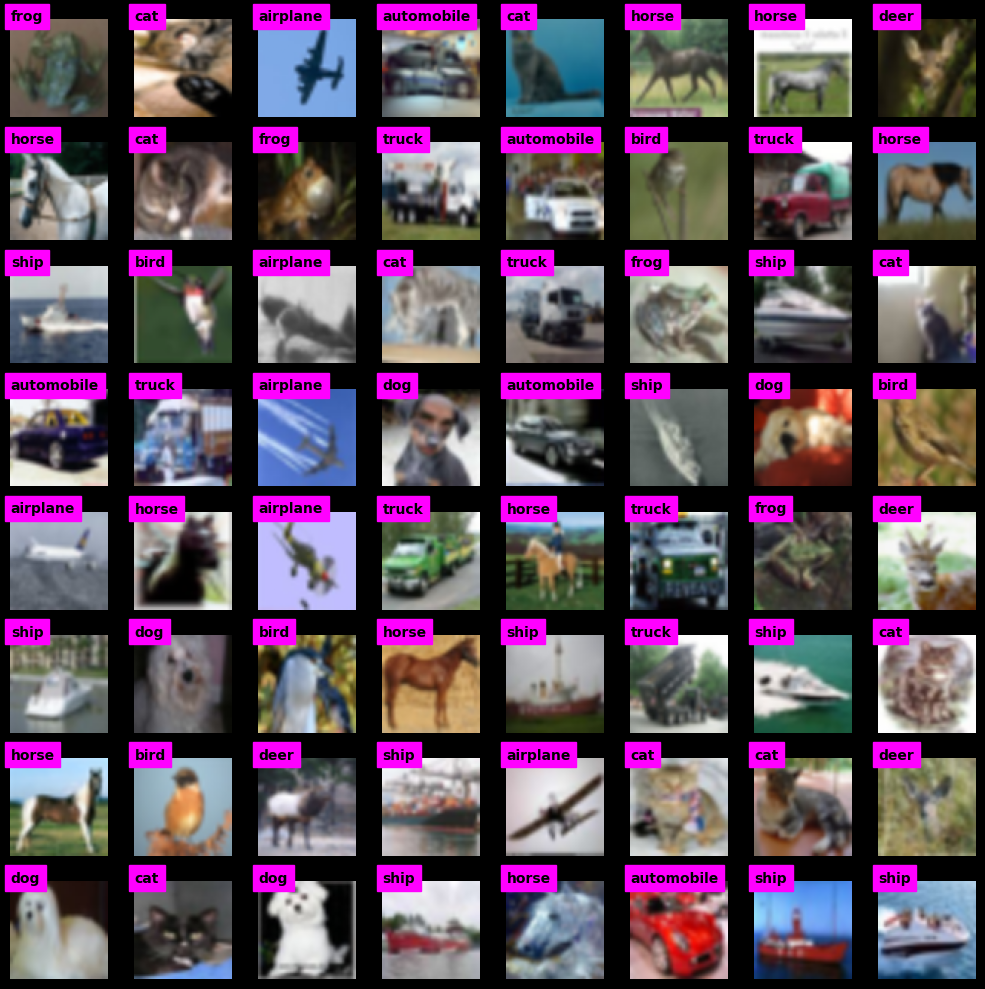

In [5]:
fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for (i, ax) in enumerate(axs.flatten()):

    # Extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1, 2, 0))
    pic = pic/2 + 0.5  # Undo Normalization

    # Label
    label = train_dataset.classes[y[i]]

    ax.imshow(pic)
    ax.text(0, 0, label, ha='left', fontweight='bold', color='k', backgroundcolor='magenta')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
def weight_init(m):
    """"
    Custom weights initialization.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)

        # Batch Norm
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(125)
        self.bn4 = nn.BatchNorm2d(512)

    def forward(self, X):
        # print(x.shape)
        X = F.leaky_relu(self.conv1(X), 0.2)
        X = F.leaky_relu(self.conv2(X), 0.2)
        X = self.bn2(X)
        X = F.leaky_relu(self.conv3(X), 0.2)
        X = self.bn3(X)
        X = F.leaky_relu(self.conv4(X), 0.2)
        X = self.bn4(X)
        X = self.conv5(X)

        return torch.sigmoid(X)

In [8]:
class Generator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # Transpose Convolutional layers
        self.tconv1 = nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False)
        self.tconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False)

        # Batch Norm
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)

    def forward(self, X):
        X = self.bn1(self.tconv1(X))
        X = F.relu(X)
        X = self.bn2(self.tconv2(X))
        X = F.relu(X)
        X = self.bn3(self.tconv3(X))
        X = F.relu(X)
        X = self.bn4(self.tconv4(X))
        X = F.relu(X)
        X = torch.tanh(self.tconv5(X))
        return X

In [9]:
# Loss function
lossfun = nn.BCELoss()

# Create instances of the models
d_net = Discriminator().to(device)
d_net.apply(weight_init)

g_net = Generator().to(device)
g_net.apply(weight_init)

# Optimizer
d_optimizer = torch.optim.Adam(d_net.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(g_net.parameters(), lr=0.0002)